# **Domain Specific Analysis**

## Objectives

*   Answer business requirement 1: 
    * The client is interested to understand the patterns between an airplanes design features and its Performance features, so that the client can learn which are the most relevant variables to consider when choosing **Engine Type** (jet, piston or propjet) in the design process of a new airplane.

## Inputs

* outputs/datasets/collection/airplane_performance_study.csv

## Outputs

* generate code that answers business requirement 1 and can be used to build the Streamlit App






---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/data-driven-design/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/data-driven-design'

---

# Load Data

* Dropping the columns with Meta Data 'Model' and 'Company' since these are identifier variables not needed for the study
* Dropping the two Engine "size" features 'THR' (Force with unit lbf) and 'SHP' (Power with unit SHP). The "THR" column is occupied (otherwise showing NaN) when the "Engine Type" is categorized with Jet and the same goes for the "SHP" when the "Engine Type" is categorized with piston or propjet. These two features () are interesting from an Aircraft Design perspective but since these are different quantities with different units they become difficult/awkward to compare with each other.

In [4]:
import pandas as pd
df = pd.read_csv("/workspace/data-driven-design/outputs/datasets/collection/airplane_performance_study.csv")
df.head(10)


,Model,Company,Wing_Span,Length,Height,Multi_Engine,TP_mods,Engine_Type,THR,SHP,...,Vstall,Range,Hmax,Hmax_(One),ROC,ROC_(One),Vlo,Slo,Vl,Sl
0,15 AC Sedan,Aeronca,37.416667,25.250000,10.250000,False,False,0,NaN,145.0,...,46.0,370.0,13000.0,13000.0,450.0,450.0,900.0,391.970247,1300.0,257.745075
1,11 CC Super Chief,Aeronca,36.083333,20.583333,8.750000,False,False,0,NaN,85.0,...,44.0,190.0,12300.0,12300.0,600.0,600.0,720.0,26.247647,800.0,225.324824
2,7 CCM Champ,Aeronca,35.000000,21.416667,8.583333,False,False,0,NaN,90.0,...,37.0,210.0,16000.0,16000.0,650.0,650.0,475.0,363.139711,850.0,585.751317
3,7 DC Champ,Aeronca,35.000000,21.416667,8.583333,False,False,0,NaN,85.0,...,37.0,210.0,13000.0,13000.0,620.0,620.0,500.0,407.797297,850.0,642.046166
4,7 AC Champ,Aeronca,35.000000,21.416667,8.750000,False,False,0,NaN,65.0,...,33.0,175.0,12500.0,12500.0,370.0,370.0,632.0,297.056192,885.0,329.571813
5,11 AC Chief,Aeronca,36.083333,20.333333,8.750000,False,False,0,NaN,65.0,...,33.0,180.0,11000.0,11000.0,360.0,360.0,583.0,393.226454,880.0,542.445142
6,PA-60-700P Aerostar (preliminary),Aerostar Aircraft Corporation,36.666667,34.833333,12.083333,True,False,0,NaN,350.0,...,80.0,868.0,25000.0,14500.0,1820.0,320.0,3080.0,1950.000000,2100.0,1425.000000
7,PA-602P Aerostar,Aerostar Aircraft Corporation,36.583333,34.750000,12.083333,True,False,0,NaN,290.0,...,77.0,1020.0,28000.0,12900.0,1755.0,302.0,2250.0,1800.000000,2076.0,1217.000000
8,PA-601P pressurized Aerostar ('77 service ceil...,Aerostar Aircraft Corporation,36.666667,34.833333,12.083333,True,False,0,NaN,290.0,...,77.0,1101.0,25000.0,8800.0,1460.0,240.0,2490.0,1900.000000,2030.0,1230.000000
9,PA-601B turbochg Aerostar (prior'80=less perf),Aerostar Aircraft Corporation,36.666667,34.833333,12.083333,True,False,0,NaN,290.0,...,77.0,1174.0,30000.0,8800.0,1460.0,240.0,2490.0,1900.000000,2030.0,1230.000000


---

# Data Exploration from the domain specific perspective of Airplane Design and Performance

## Mean and extremes in the data set

We are interested to get more familiar with the dataset and to see if we can pin which airplanes that constitutes the most average and extremes in the data set. 

Note that the the boolean values for Multi Engine and TP mods are treated as 1 (for True) and 0 (for False) meaning that the mean is the average of these boolean values so that a mean opf 0.5 would mean eaually many True and False instances and for example a mean of 0.6 would be a few more True than False.

The Categorical feature Engine Type has three values 0 (for Jet), 1 (for piston) and 2 (for propjet). The mean is calculated in the same fashion here albeit the intepretation becomes more difficult since a mean of 1 could be both zero or all having the engine type of jet prop.
Consider how to do with the categorical values (Multi_Engine, TP_mods, Engine_Type) as well as those dependent on the categorical values (TP mods, THR and SHP, Hmax (One) and ROC(One)).

Acclaim Ultra (M20V) (Mooney Aircraft) MIN: 280.0 is selected for the min value for THR - feature. Mighty strange since it has a prop. Probable explanation is that this value still exxist for this airplane (check!). This airplane is with a Vmax of 242 knots the fastest single-engine production piston aircraft in the world. The Engine Type and Multi_Engine for this airplane, I just discovered (Vmax is however correct) is incorrect. It should be a Engine Type: Piston and Multi Engine: false and these wrong entries is the reason for why it appears in the min THR category. I have NOT corrected this error yet.  

In [5]:
import pandas as pd

# Assuming df is defined and contains the relevant features and company/model columns
# Create an empty DataFrame with columns showing what I want to display
columns = ['FEATURE', 'MIN_model', 'MIN_company', 'MIN_value', 
           'MEAN_model', 'MEAN_company', 'MEAN_value', 
           'MAX_model', 'MAX_company', 'MAX_value']
df_summary_stats = pd.DataFrame(columns=columns)

# Fill the 'FEATURE' column with all relevant features leaving the categorical values out ('Multi_Engine', 'TP_mods', 'Engine_Type')
df_summary_stats['FEATURE'] = ['Wing_Span', 'Length', 'Height', 
                                'THR', 'SHP', 'AUW', 'MEW',
                                'FW', 'Vmax', 'Vcruise', 'Vstall',
                                'Range', 'Hmax', 'Hmax_(One)',
                                'ROC', 'ROC_(One)', 'Vlo', 'Slo',
                                'Vl', 'Sl']

# Calculate statistics and fill df_summary_stats
for feature in df_summary_stats['FEATURE']:
    if feature in df.columns:
        # Minimum statistics
        min_value = df[feature].min()
        min_index = df[feature].idxmin()
        df_summary_stats.loc[df_summary_stats['FEATURE'] == feature, 'MIN_model'] = df.loc[min_index, 'Model']
        df_summary_stats.loc[df_summary_stats['FEATURE'] == feature, 'MIN_company'] = df.loc[min_index, 'Company']
        df_summary_stats.loc[df_summary_stats['FEATURE'] == feature, 'MIN_value'] = min_value

        # Mean statistics
        mean_value = df[feature].mean()
        df_summary_stats.loc[df_summary_stats['FEATURE'] == feature, 'MEAN_value'] = mean_value
        
        # Finding the closest value to the mean
        closest_index = (df[feature] - mean_value).abs().idxmin()
        df_summary_stats.loc[df_summary_stats['FEATURE'] == feature, 'MEAN_model'] = df.loc[closest_index, 'Model']
        df_summary_stats.loc[df_summary_stats['FEATURE'] == feature, 'MEAN_company'] = df.loc[closest_index, 'Company']

        # Maximum statistics
        max_value = df[feature].max()
        max_index = df[feature].idxmax()
        df_summary_stats.loc[df_summary_stats['FEATURE'] == feature, 'MAX_model'] = df.loc[max_index, 'Model']
        df_summary_stats.loc[df_summary_stats['FEATURE'] == feature, 'MAX_company'] = df.loc[max_index, 'Company']
        df_summary_stats.loc[df_summary_stats['FEATURE'] == feature, 'MAX_value'] = max_value
    else:
        print(f"Feature '{feature}' not found in the DataFrame.")

df_summary_stats


,FEATURE,MIN_model,MIN_company,MIN_value,MEAN_model,MEAN_company,MEAN_value,MAX_model,MAX_company,MAX_value
0,Wing_Span,182S ('97 & up),Cessna Aircraft Company,16.0,TBM 850,EADS Socata Aircraft,41.355815,Global 7500,Bombardier Aerospace Business Aircraft,104.0
1,Length,M18 Mite,Mooney Aircraft,17.583333,PA-31P-350 Mojave,Piper Aircraft,34.482118,Lineage 1000,Embraer Aircraft - Empresa Brasileira,118.916667
2,Height,A-2,Aircoupe-Alon,5.083333,421 - A & B,Cessna Aircraft Company,11.347784,Lineage 1000,Embraer Aircraft - Empresa Brasileira,33.75
3,THR,Acclaim Ultra (M20V),Mooney Aircraft,280.0,Hawker 750,Hawker Beechcraft,5458.318182,Global 7500,Bombardier Aerospace Business Aircraft,18920.0
4,SHP,7ACA,American Champion Aircraft Corporation,60.0,58 P Baron-press.('77 hgt=9/6) (range based on...,Beechcraft (Hawker Beechcraft),314.835704,GI (G-159) ceiling quoted w/APU,Gulfstream Aerospace,1950.0
5,AUW,M18 Mite,Mooney Aircraft,850.0,Merlin II A,Fairchild M7 Aerospace,9754.535589,Lineage 1000,Embraer Aircraft - Empresa Brasileira,120152.0
6,MEW,M18 Mite,Mooney Aircraft,575.0,"MU-2B,-2D (-2D=9,350 gross weight)",Mitsubishi Diamond,5724.573852,Lineage 1000,Embraer Aircraft - Empresa Brasileira,70841.0
7,FW,J-3 Cub,Piper Aircraft,60.3,EMB-110P1A Bandeirante (specs=110P1/41),Embraer Aircraft - Empresa Brasileira,2905.49704,Lineage 1000,Embraer Aircraft - Empresa Brasileira,48217.0
8,Vmax,J-3 Cub,Piper Aircraft,76.0,T 310 Q turbocharged,Cessna Aircraft Company,238.052178,Global 7500,Bombardier Aerospace Business Aircraft,616.975
9,Vcruise,DW-1 (ag plane),Eagle,57.0,"C 90,C90-1 (-1 has increased speed)",Beechcraft (Hawker Beechcraft),216.686923,Global 7500,Bombardier Aerospace Business Aircraft,566.95


In [6]:
df_summary_stats.to_csv('outputs/datasets/collection/df_summary_stats.csv', index=False)

---

## Make a good title here

In [8]:
filtered_df = df[df['Company'].isin(['Cessna Aircraft Company', 'Piper Aircraft'])]
print(filtered_df)

                       Model                  Company  Wing_Span     Length  \
221       Citation Longitude  Cessna Aircraft Company  68.916667  73.166667   
222           750 Citation X  Cessna Aircraft Company  63.750000  72.166667   
223              Citation X+  Cessna Aircraft Company  69.166667  73.583333   
224  Citation Sovereign+ 680  Cessna Aircraft Company  72.250000  63.416667   
225   680 Citation Sovereign  Cessna Aircraft Company  63.333333  63.583333   
..                       ...                      ...        ...        ...   
736            PA-16 Clipper           Piper Aircraft  29.166667  20.083333   
737            PA-14 Cruiser           Piper Aircraft  35.333333  23.083333   
738      PA-12 Super Cruiser           Piper Aircraft  35.333333  22.750000   
739                    PA-11           Piper Aircraft  35.166667  22.333333   
740                  J-3 Cub           Piper Aircraft  35.166667  22.333333   

        Height  Multi_Engine  TP_mods  Engine_Type 

---

## Range dependencie on proportion of fuel Weight

The Range Equation (derived from the Breguet equations) include the proportion of the fuel weight to the overal weight of the aircraft. It measures this by the relationship between the initial weight of the aircraft (before take off) to the weight of the airplane (after landing) after the fuel has been burned off.
A very interesting pattern emerges where it is not linear but also not exponential, rather a sort of two-phased linearity with one slope up untill a 'Wi/Wf' 1.35 after which the slope changes abruptly. Perhaps the reason for this suprise pattern lies in the the Engine types. This would warrant the same ploit to be printed with the different Engine types separatly!

<img src="/workspace/data-driven-design/images_notebook/range_eq.png" alt="Range Equationr" height="300" />

We have manually identified (by scrolling the Wi/Wf column) and removed the outlier that must be due to erroniouos data in FW and/or AUW.

In [11]:
import pandas as pd
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns

print(df)

                                                 Model  \
0                                          15 AC Sedan   
1                                    11 CC Super Chief   
2                                          7 CCM Champ   
3                                           7 DC Champ   
4                                           7 AC Champ   
5                                          11 AC Chief   
6                    PA-60-700P Aerostar (preliminary)   
7                                     PA-602P Aerostar   
8    PA-601P pressurized Aerostar ('77 service ceil...   
9       PA-601B turbochg Aerostar (prior'80=less perf)   
10                     PA-601, 601A, turbochg Aerostar   
11                               PA-600,600A,-Aerostar   
12                     G164B Turbine (spec for 680 hp)   
13          G164C-600 AG-CAT (design category) sprayer   
14          G164B-600 AG-CAT (design category) sprayer   
15                  G164A-600 AG-CAT (design category)   
16    G164B-52

In [12]:
# Print features for data point in row 467
data_point = df.iloc[467]
print(data_point)

Model            TBM 940 (2019 & Up)
Company         EADS Socata Aircraft
Wing_Span                  42.083333
Length                     35.166667
Height                         14.25
Multi_Engine                   False
TP_mods                        False
Engine_Type                        1
THR                              NaN
SHP                            850.0
AUW                           7394.0
MEW                           4629.0
FW                            6032.0
Vmax                           330.0
Vcruise                        252.0
Vstall                     91.828552
Range                         1730.0
Hmax                         31000.0
Hmax_(One)                   31000.0
ROC                           1653.0
ROC_(One)                     1653.0
Vlo                      2423.542163
Slo                           2380.0
Vl                       2152.050052
Sl                            2430.0
Name: 467, dtype: object


In [13]:
# Remove the row at index 467 from the DataFrame
df = df.drop(index=467).reset_index(drop=True)

                                                 Model  \
0                                          15 AC Sedan   
1                                    11 CC Super Chief   
2                                          7 CCM Champ   
3                                           7 DC Champ   
4                                           7 AC Champ   
5                                          11 AC Chief   
6                    PA-60-700P Aerostar (preliminary)   
7                                     PA-602P Aerostar   
8    PA-601P pressurized Aerostar ('77 service ceil...   
9       PA-601B turbochg Aerostar (prior'80=less perf)   
10                     PA-601, 601A, turbochg Aerostar   
11                               PA-600,600A,-Aerostar   
12                     G164B Turbine (spec for 680 hp)   
13          G164C-600 AG-CAT (design category) sprayer   
14          G164B-600 AG-CAT (design category) sprayer   
15                  G164A-600 AG-CAT (design category)   
16    G164B-52

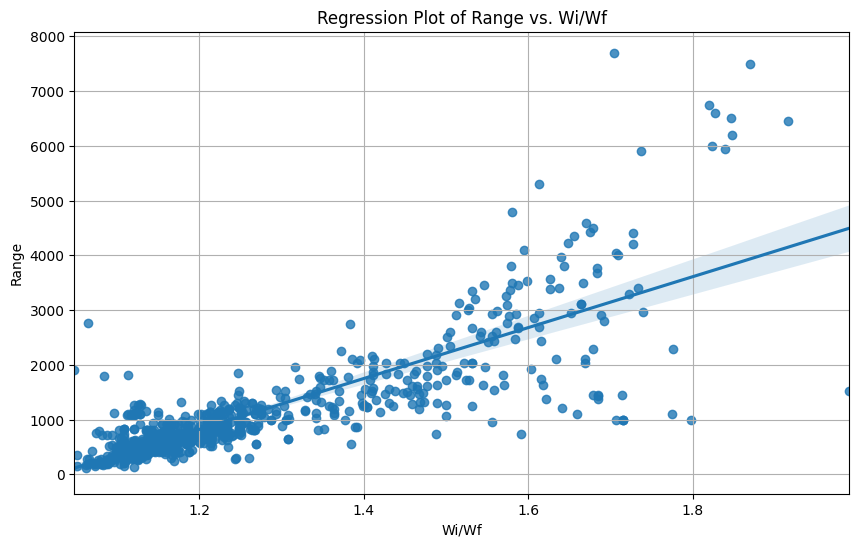

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Calculate Wi / Wf based on the formula
df['Wi/Wf'] = df['AUW'] / (df['AUW'] - df['FW'])

# Print the DataFrame with the new feature
print(df)

# Create a regression plot using seaborn
plt.figure(figsize=(10, 6))
sns.regplot(x='Wi/Wf', y='Range', data=df)
plt.title('Regression Plot of Range vs. Wi/Wf')
plt.xlabel('Wi/Wf')
plt.ylabel('Range')
plt.grid()
plt.show()


---

## Ceiling as a function of Wing Span

Finally, my former prof. Peter Lissaman found, when developing the solar powered High Altitude Airplanes Helios (Wing Span: 75 m) at Aerovironment/NASA, that Hmax was completly dependent on Wing Span. Since this is not obvious from the equations of Hmax it will be interesting to see if this also applies to General Aviation.

<br>
<img src="/workspace/data-driven-design/images_notebook/helios.jpg" alt="Equation for" style="width: 40%;"/>

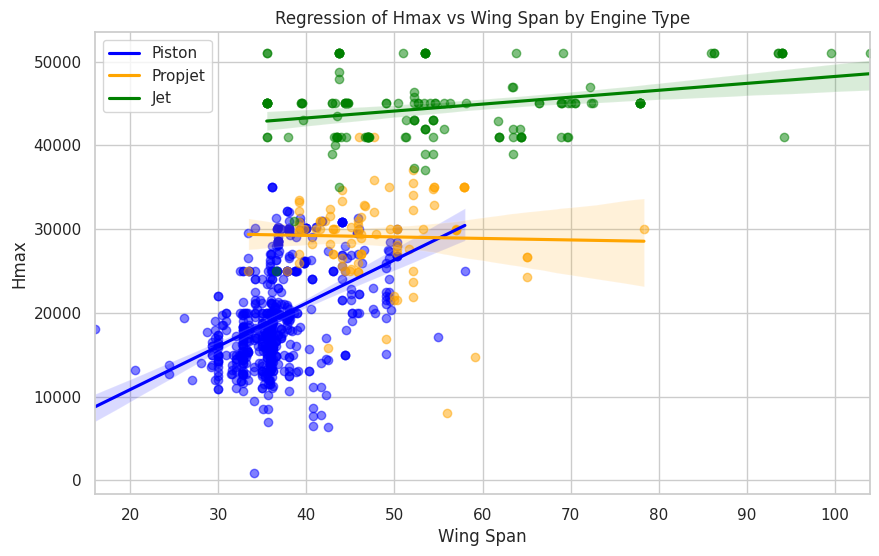

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style for the plot
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(10, 6))

# Plot regression line for Piston (Engine_Type = 0)
sns.regplot(x='Wing_Span', y='Hmax', data=df[df['Engine_Type'] == 0], 
            scatter_kws={'alpha': 0.5}, 
            line_kws={'label': 'Piston'}, 
            color='blue')

# Plot regression line for Propjet (Engine_Type = 1)
sns.regplot(x='Wing_Span', y='Hmax', data=df[df['Engine_Type'] == 1], 
            scatter_kws={'alpha': 0.5}, 
            line_kws={'label': 'Propjet'}, 
            color='orange')

# Plot regression line for Jet (Engine_Type = 2)
sns.regplot(x='Wing_Span', y='Hmax', data=df[df['Engine_Type'] == 2], 
            scatter_kws={'alpha': 0.5}, 
            line_kws={'label': 'Jet'}, 
            color='green')

# Add legend and titles
plt.legend()
plt.title('Regression of Hmax vs Wing Span by Engine Type')
plt.xlabel('Wing Span')
plt.ylabel('Hmax')

# Plot
plt.show()
